In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [6]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)

,Id,rsem.out.S442_NT,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4520,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,14,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [7]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp"}


pgenes_df =  genes_exp_df[ genes_exp_df["strand"] == "+" ][tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)
mgenes_df =  genes_exp_df[ genes_exp_df["strand"] == "-" ][tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

pgenes_df["size"] = pgenes_df["end"] - pgenes_df["start"]
mgenes_df["size"] = mgenes_df["end"] - mgenes_df["start"]

In [8]:
pgenes_df = pgenes_df.sort_values(["chrom","start"])
pgenes_df = pgenes_df[pgenes_df["chrom"].isin(autosomal_chroms)]
pgenes_df = pgenes_df.reset_index(drop=True)
pgenes_df.head(3)

,chrom,start,end,exp,size
0,chr1,11873,14409,0,2536
1,chr1,69090,70008,0,918
2,chr1,752750,755214,0,2464


In [9]:
mgenes_df = mgenes_df.sort_values(["chrom","start"])
mgenes_df = mgenes_df[mgenes_df["chrom"].isin(autosomal_chroms)]
mgenes_df = mgenes_df.reset_index(drop=True)
mgenes_df.head(3)

,chrom,start,end,exp,size
0,chr1,14361,29370,32,15009
1,chr1,134772,140566,0,5794
2,chr1,562759,564389,0,1630


In [10]:
fig5_samples = ["ins_CTCF",
                "ins_noCTCF",
                "ins_polII",
                "ins_nopolII",
                "ev1_CTCF",
                "ev1_noCTCF",
                "ev1_polII",
                "ev1_nopolII",
                "polII",
                'h3k4_r1',
                "mrna_ctcf",
                "mrna_noctcf"]

Text(0.5, 0, 'transcript size, bp')

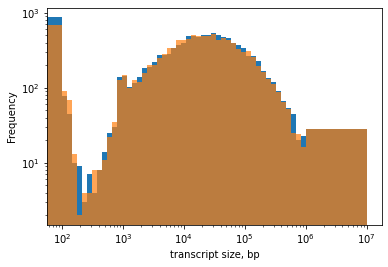

In [11]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
pgenes_df["size"].plot.hist(bins=bins,log=True)
mgenes_df["size"].plot.hist(bins=bins,log=True,alpha=0.7)
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")

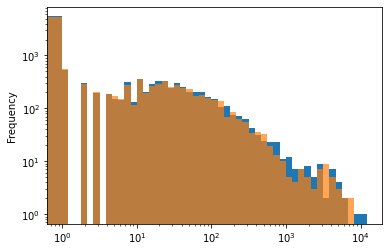

In [12]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
pgenes_df["exp"].plot.hist(bins=bins,log=True)
mgenes_df["exp"].plot.hist(bins=bins,log=True,alpha=0.7)
ax = plt.gca()
ax.set_xscale("log")

In [13]:
pgenes_df["gexp"] = pd.cut(
    pgenes_df["exp"],
    bins=[0,0.5,14,70,np.inf],
    labels=("no","low","med","high"),
    include_lowest=True
)
pgenes_df["gsize"] = pd.cut(
    pgenes_df["size"],
    bins=[0,10_000,80_000,np.inf],
    labels=("short","medium","long"),
    include_lowest=True
)
display(pgenes_df.head())


mgenes_df["gexp"] = pd.cut(
    mgenes_df["exp"],
    bins=[0,0.5,14,70,np.inf],
    labels=("no","low","med","high"),
    include_lowest=True
)
mgenes_df["gsize"] = pd.cut(
    mgenes_df["size"],
    bins=[0,10_000,80_000,np.inf],
    labels=("short","medium","long"),
    include_lowest=True
)
display(mgenes_df.head())
display(pgenes_df.groupby(["gexp","gsize"]).size().unstack(fill_value=0))
display(mgenes_df.groupby(["gexp","gsize"]).size().unstack(fill_value=0))

,chrom,start,end,exp,size,gexp,gsize
0,chr1,11873,14409,0,2536,no,short
1,chr1,69090,70008,0,918,no,short
2,chr1,752750,755214,0,2464,no,short
3,chr1,762970,794826,12,31856,low,medium
4,chr1,859302,879954,1,20652,low,medium


,chrom,start,end,exp,size,gexp,gsize
0,chr1,14361,29370,32,15009,med,medium
1,chr1,134772,140566,0,5794,no,short
2,chr1,562759,564389,0,1630,no,short
3,chr1,661138,714014,5,52876,low,medium
4,chr1,761585,762902,3,1317,low,short


gsize,short,medium,long
gexp,,,
no,2774,1981,715
low,579,1258,682
med,388,1277,528
high,331,702,95


gsize,short,medium,long
gexp,,,
no,2683,1966,711
low,633,1191,654
med,369,1250,480
high,314,660,73


In [14]:
mgenes_df["start"] = mgenes_df["start"] - mgenes_df["size"]
mgenes_df["end"] = mgenes_df["end"] + mgenes_df["size"]

pgenes_df["start"] = pgenes_df["start"] - pgenes_df["size"]
pgenes_df["end"] = pgenes_df["end"] + pgenes_df["size"]

In [15]:
samples.keys()

dict_keys(['ctcf', 'noctcf', 'rad21_CTCF', 'rad21_noCTCF', 'rad21_wt1', 'rad21_rad21', 'rad21_norad21', 'G4a_r2', 'Rloop_K562', 'ddx_CTCF', 'ddx_noCTCF', 'taf5l_CTCF', 'taf5l_noCTCF', 'ddx_CTCF_r2', 'ddx_noCTCF_r2', 'taf5l_CTCF_r2', 'taf5l_noCTCF_r2', 'rad21_CTCF_r2', 'rad21_noCTCF_r2', 'input_CTCF_r2', 'input_noCTCF_r2', 'input_CTCF_r3', 'input_noCTCF_r3', 'input_CTCF', 'input_noCTCF', 'polII', 'h3k4_r1', 'h3k4_r2', 'h3k4_input', 'h3k4_k562', 'ins_CTCF', 'ins_noCTCF', 'ins_polII', 'ins_nopolII', 'ins_rad21', 'ins_norad21', 'ins_mutCtr_CTCF', 'ins_mutCtr_noCTCF', 'ins_mutDDX_CTCF', 'ins_mutDDX_noCTCF', 'ins_mutTAF_CTCF', 'ins_mutTAF_noCTCF', 'ins_siCtr_CTCF', 'ins_siCtr_noCTCF', 'ins_siDDX_CTCF', 'ins_siDDX_noCTCF', 'ins_siTAF_CTCF', 'ins_siTAF_noCTCF', 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII', 'ev1_rad21', 'ev1_norad21', 'ev1_mutCtr_CTCF', 'ev1_mutCtr_noCTCF', 'ev1_mutDDX_CTCF', 'ev1_mutDDX_noCTCF', 'ev1_mutTAF_CTCF', 'ev1_mutTAF_noCTCF', 'ev1_siCtr_CTCF', 'ev1_siCtr_noCTC

In [51]:
# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_ins(df):
    """for a BED-like DF, extract 'signal' from BW for every interval"""
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    samples["Rloop_K562"]["fname"],
                    chrom,
                    start,
                    end,
                    bins=3000,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )

def extract_ins_stack(df):
    """for a BED-like DF, extract stack-'signal' from BW for every interval"""
    return np.asarray([
        bbi.fetch
               (
                    samples["Rloop_K562"]["fname"],
                    chrom,
                    start,
                    end,
                    bins=3000,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.sort_values(by="size").itertuples(index=False)
    ])


In [52]:
pgene_profiles = pgenes_df.groupby(["gexp","gsize"]).apply(extract_ins)
mgene_profiles = mgenes_df.groupby(["gexp","gsize"]).apply(extract_ins)

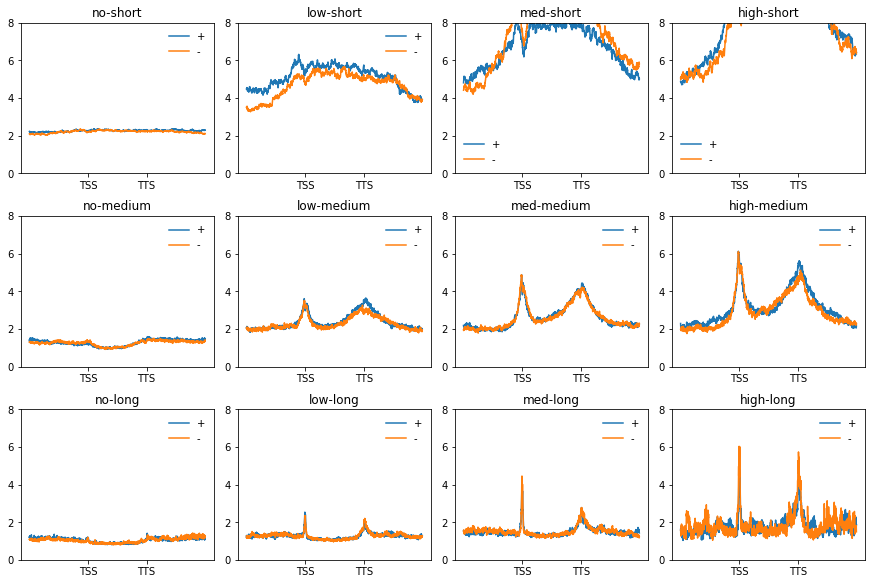

In [54]:
# xxx.to_dict().keys()
glens=("short","medium","long")
gexps=("no","low","med","high")

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        ax.plot(pgene_profiles[(gexp,glen)],label="+")
        ax.plot(mgene_profiles[(gexp,glen)][::-1],label="-")
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(0,8)
#         ax.set_ylim(0,500)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

In [55]:
pgene_profiles = pgenes_df.groupby(["gexp","gsize"]).apply(extract_ins_stack)
mgene_profiles = mgenes_df.groupby(["gexp","gsize"]).apply(extract_ins_stack)

In [58]:
def plot_sss(
          hmss, # will become a dictionary now (or list) ...
          titles,
          limss,
          cmps,
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=False,
          interpolation="nearest",
          inch_per_1k_stack= 1.2, #inches per 1000 elements stackup ...
         ):
    # rewrite everyhting assuming hmss is a dict of stackup groups !
    # groups are plotted on top of each other ...
    
    # regardless - claculate number of axes for stackups ...
    num_stackup_groups = len(hmss)
    # pick in every stackup group and see how many are there
    num_stackups = max(len(hmss[k]) for k in hmss)
    num_rows = num_stackups
    # let's figure out - how tall is this stackup
    # get heights of stackups from each groups
    stackup_group_heights = [len(hmss[k][0]) for k in hmss]
    stackup_height = sum(stackup_group_heights)*inch_per_1k_stack/1_000
    figure_height = stackup_height + 2.5
    fig = plt.figure(
        figsize=(3.5*num_rows, figure_height),
        facecolor="white",
        constrained_layout=True
    )
    gs = fig.add_gridspec(
        num_stackup_groups+2,
        num_rows,
        width_ratios=[1]*num_rows,
        height_ratios = \
            [0.95*2.5/figure_height] + \
            [(_h/sum(stackup_group_heights))*(figure_height-2.5)/figure_height for _h in stackup_group_heights] + \
            [0.05*2.5/figure_height]
    )

    ax_profile = {}
    ax_stackup = {}
    ax_cbar = {}
    hmss_order = list( range(num_rows) )
    # replace following with the pre-defined column indexes ...
    for idx in hmss_order:
        ax_profile[idx] = fig.add_subplot(gs[0,idx])
        ax_stackup[idx] = [fig.add_subplot(gs[_i+1,idx]) for _i in range(num_stackup_groups)] # stackup groups ...
        ax_cbar[idx] = fig.add_subplot(gs[-1,idx])

    hm_arr = {}
    profile_hm = {}
    labels_dict = {}
    # for each group of stackups (vertically set)
    for group_id, k in enumerate(hmss):
        hm_arr[group_id] = {}
        profile_hm[group_id] = {}
        labels_dict[group_id] = {}
        # for every stackup in each group (horizontal set)
        for idx, hm in zip(hmss_order, hmss[k]):
            if fillmissing:
                X = hm[:]
                missing = ~np.isfinite(X)
                mu = np.nanmean(X, axis=0, keepdims=True) # axis 0 or 1 - rows or columns ?!
                hm_arr[group_id][idx] = np.where(missing, mu, X)
            else:
                hm_arr[group_id][idx] = hm[:]
            profile_hm[group_id][idx] = np.nanmean(hm_arr[group_id][idx],axis=0)
            labels_dict[group_id][idx] = k
    
    # turning some of the input parameters into "oredered" or labeled dicts ...
    if norms is None:
        norms = { _i:None for _i in hmss_order}
    else:
        norms = { _i:norms[i] for i,_i in enumerate(hmss_order)}
    vlims = { _i:limss[i] for i,_i in enumerate(hmss_order)}
    titles = { _i:titles[i] for i,_i in enumerate(hmss_order)}
    if binsizes is None:
        binsizes = { _i:1 for _i in hmss_order}
    else:
        binsizes = { _i:binsizes[i] for i,_i in enumerate(hmss_order)}

    for idx, cmap in zip(hmss_order, cmps):
        # plot profiles from every group on a single common axis for profiles...
        for _i in range(num_stackup_groups):
            ax_profile[idx].plot(profile_hm[_i][idx], label=labels_dict[_i][idx])
        ax_profile[idx].set_yscale("linear" if norms[idx] is None else "log")
        ax_profile[idx].legend(frameon=False)
        # stackups for every group ...
        for _i in range(num_stackup_groups):
            stack_hm = ax_stackup[idx][_i].imshow(
                              hm_arr[_i][idx],
                              norm=norms[idx],
                              aspect="auto",
                              vmin=vlims[idx][0],
                              vmax=vlims[idx][1],
                              cmap=cmap,
                              interpolation=interpolation,
            )
        # beautify ...
        group_id_beautify = 0
        first_bin = 0-.5
        center_bin = hm_arr[group_id_beautify][idx].shape[1]/2 - .5
        last_bin = hm_arr[group_id_beautify][idx].shape[1]-.5
        ax_profile[idx].set_xlim([first_bin, last_bin])
        ax_profile[idx].set_ylim(vlims[idx])
        ax_profile[idx].set_title(titles[idx])
        # human readable kb stuff:
        flank_in_kb = int((center_bin+.5)*binsizes[idx]/1000)
        flank_ticks = [first_bin, center_bin, last_bin]
        flank_ticklabels = [-flank_in_kb, 0, flank_in_kb]
        ax_profile[idx].set_xticks(flank_ticks)
        ax_profile[idx].set_xticklabels(flank_ticklabels)
        for _i in range(num_stackup_groups-1):
            ax_stackup[idx][_i].set_xticks([])
            ax_stackup[idx][_i].set_xticklabels([])
            ax_stackup[idx][_i].set_yticks([])
            ax_stackup[idx][_i].set_yticklabels([])
        # bottom one - show ticks for now ...
        _i = num_stackup_groups-1
        ax_stackup[idx][_i].set_xticks(flank_ticks)
        ax_stackup[idx][_i].set_xticklabels(flank_ticklabels)
        ax_stackup[idx][_i].set_yticks([])
        ax_stackup[idx][_i].set_yticklabels([])
        plt.colorbar(stack_hm,cax=ax_cbar[idx],orientation="horizontal")
        
    return None


In [59]:
# idxxx = np.argsort(np.nanmean((pgene_profiles[("high","medium")])[:,1000:2000],axis=1))
# plt.imshow(pgene_profiles[("high","medium")][idxxx],vmin=-1,vmax=1,aspect=5,cmap="coolwarm")
# plt.imshow(pgene_profiles[("high","medium")][idxxx],vmin=0,vmax=0.5,aspect=5,interpolation="nearest")
# plt.imshow(pgene_profiles[("no","long")],vmin=-0.5,vmax=0.5,aspect=5,cmap="coolwarm")

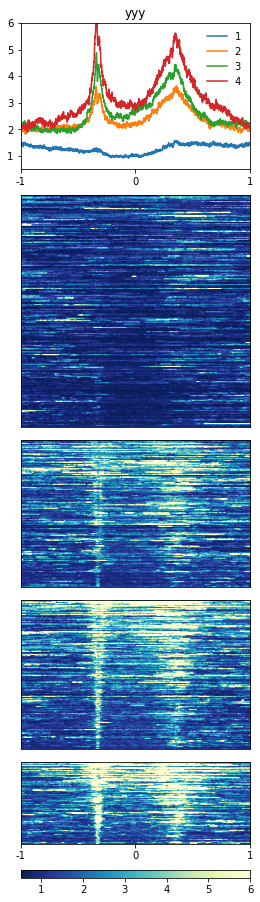

In [65]:
# ordered by the gene size ...
plot_sss( hmss = {"1":[pgene_profiles[("no","medium")]],
                  "2":[pgene_profiles[("low","medium")]],
                  "3":[pgene_profiles[("med","medium")]],
                  "4":[pgene_profiles[("high","medium")]],
                 },
          titles = ["yyy"],
          limss = [(.5,6)],
          cmps = ["YlGnBu_r"],
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=True,
          interpolation="bilinear",
          inch_per_1k_stack = 1.9,
         )

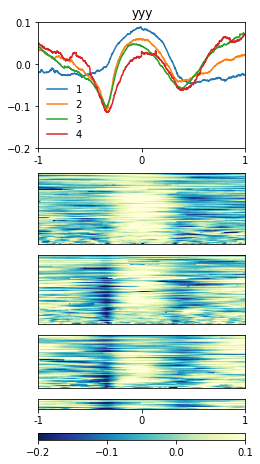

In [50]:
# ordered by the gene size ...
plot_sss( hmss = {"1":[pgene_profiles[("no","long")] - np.nanmean(pgene_profiles[("no","long")],axis=1,keepdims=True)],
                  "2":[pgene_profiles[("low","long")] - np.nanmean(pgene_profiles[("low","long")],axis=1,keepdims=True)],
                  "3":[pgene_profiles[("med","long")] - np.nanmean(pgene_profiles[("med","long")],axis=1,keepdims=True)],
                  "4":[pgene_profiles[("high","long")] - np.nanmean(pgene_profiles[("high","long")],axis=1,keepdims=True)],
                 },
          titles = ["yyy"],
          limss = [(-0.2,0.1)],
          cmps = ["YlGnBu_r"],
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=True,
          interpolation="bilinear",
          inch_per_1k_stack = 1.9,
         )

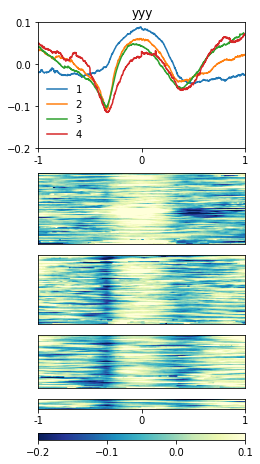

In [49]:
# reordered some other way ...
idxxx = {}
idxxx[("no","long")] = np.argsort( np.nanmean( pgene_profiles[("no","long")],axis=1 ) )
idxxx[("low","long")] = np.argsort( np.nanmean( pgene_profiles[("low","long")],axis=1 ) )
idxxx[("med","long")] = np.argsort( np.nanmean( pgene_profiles[("med","long")],axis=1 ) )
idxxx[("high","long")] = np.argsort( np.nanmean( pgene_profiles[("high","long")],axis=1 ) )

plot_sss( hmss = {"1":[pgene_profiles[("no","long")][idxxx[("no","long")]] - np.nanmean(pgene_profiles[("no","long")],axis=1,keepdims=True)[idxxx[("no","long")]]],
                  "2":[pgene_profiles[("low","long")][idxxx[("low","long")]] - np.nanmean(pgene_profiles[("low","long")],axis=1,keepdims=True)[idxxx[("low","long")]]],
                  "3":[pgene_profiles[("med","long")][idxxx[("med","long")]] - np.nanmean(pgene_profiles[("med","long")],axis=1,keepdims=True)[idxxx[("med","long")]]],
                  "4":[pgene_profiles[("high","long")][idxxx[("high","long")]] - np.nanmean(pgene_profiles[("high","long")],axis=1,keepdims=True)[idxxx[("high","long")]]],
                 },
          titles = ["yyy"],
          limss = [(-0.2,0.1)],
          cmps = ["YlGnBu_r"],
          norms=None,
          binsizes=None,
          labels=None,
          fillmissing=True,
          interpolation="bilinear",
          inch_per_1k_stack = 1.9,
         )

In [ ]:

pcriteria= (pgenes_df["exp"]>10)&(pgenes_df["exp"]<100) & \
        (pgenes_df["size"]>10_000) &  (pgenes_df["size"]<100_000)
print(f"{pcriteria.sum()} m-genes satisfy the criteria ...")
ttt = np.asarray([ bbi.fetch(
        samples["ins_CTCF"]["fname"],
        chrom,
        start,
        end,
        bins=1000,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
  for chrom,start,end,exp,size in pgenes_df[pcriteria].itertuples(index=False)
])


mcriteria= (mgenes_df["exp"]>10) &(mgenes_df["exp"]<100) & \
        (mgenes_df["size"]>10_000) & (mgenes_df["size"]<100_000)
print(f"{mcriteria.sum()} m-genes satisfy the criteria ...")
rrr = np.asarray([ bbi.fetch(
        samples["ins_CTCF"]["fname"],
        c,
        s,
        e,
        bins=1000,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
  for c,s,e,exp,size in mgenes_df[mcriteria].itertuples(index=False)
])

In [ ]:
#! ls CkoCT442_NT_pool.hg19.5kb.*.bw

In [ ]:
plt.plot(np.nanmean(rrr,axis=0)[::-1],label="minus")
plt.plot(np.nanmean(ttt,axis=0),label="plus")
ax = plt.gca()
ax.set_xticks([0,1000])
ax.set_xticklabels(["TSS","TTS"])
ax.legend()
# ax.set_ylim(-0.16,0.1)

In [ ]:
plt.plot(ttt.T,alpha=0.1,color="red");

In [ ]:
for i,c,s,e,exp in pgenes_df[pgenes_df["exp"]>200].itertuples(index=True):
    _xxx = bbi.fetch(
        samples["ins_CTCF"]["fname"],
        c,
        s,
        e,
        bins=1000,
        missing=0.0,
        oob=np.nan,
        summary='mean',
    )
#     plt.plot(np.linspace(0,1,len(_xxx)),_xxx,alpha=0.1,color="red")
    plt.plot(_xxx,alpha=0.1,color="red")